In [163]:
import numpy as np
import pandas as pd

from sklearn import model_selection
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [81]:
data = pd.concat([
    pd.read_csv("../input/pageviews.zip", parse_dates=["FEC_EVENT"]),
    pd.read_csv("../input/pageviews_complemento.zip", parse_dates=["FEC_EVENT"]),
    pd.read_csv('../input/device_data.zip', parse_dates=["FEC_EVENT"])
])

/home/jloscalzo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [82]:
X_test = []
for c in data.drop(["USER_ID", "FEC_EVENT"], axis=1).columns:
    print("haciendo", c)
    temp = pd.crosstab(data.USER_ID, data[c])
    temp.columns = [c + "_" + str(v) for v in temp.columns]
    X_test.append(temp.apply(lambda x: x / x.sum(), axis=1))
X_test = pd.concat(X_test, axis=1)

haciendo CONNECTION_SPEED
haciendo CONTENT_CATEGORY
haciendo CONTENT_CATEGORY_BOTTOM
haciendo CONTENT_CATEGORY_TOP
haciendo IS_MOBILE_DEVICE
haciendo ON_SITE_SEARCH_TERM
haciendo PAGE
haciendo SITE_ID


In [83]:
data = data[data.FEC_EVENT.dt.month < 10]
X_train = []
for c in data.drop(["USER_ID", "FEC_EVENT"], axis=1).columns:
    print("haciendo", c)
    temp = pd.crosstab(data.USER_ID, data[c])
    temp.columns = [c + "_" + str(v) for v in temp.columns]
    X_train.append(temp.apply(lambda x: x / x.sum(), axis=1))
X_train = pd.concat(X_train, axis=1)

haciendo CONNECTION_SPEED
haciendo CONTENT_CATEGORY
haciendo CONTENT_CATEGORY_BOTTOM
haciendo CONTENT_CATEGORY_TOP
haciendo IS_MOBILE_DEVICE
haciendo ON_SITE_SEARCH_TERM
haciendo PAGE
haciendo SITE_ID


In [84]:
features = list(set(X_train.columns).intersection(set(X_test.columns)))
X_train = X_train[features]
X_test = X_test[features]

In [85]:
y_prev = pd.read_csv("../input/conversiones/conversiones.csv")
y_train = pd.Series(0, index=X_train.index)
idx = (
    set(y_prev[y_prev.mes >= 10].USER_ID.unique())
    .intersection(set(X_train.index))
)
y_train.loc[list(idx)] = 1

In [86]:
y_test = pd.Series(0,index=X_test.index)
idx_test = set(y_prev.USER_ID.unique()).intersection(set(X_test.index))
y_test.loc[idx_test] = 1

In [118]:
X_test= X_test.astype('float32')
X_train=X_train.astype('float32')

In [118]:
# ExtraTreesClassifier?

In [143]:
# me fijo las columnas con nan
cols_with_nans = pd.concat(
    [
        df.apply(lambda df: df.isna().any(axis=0)).loc[lambda d: d==True] for df in [X_train, X_test]
    ]
)
cols_with_nans

IS_MOBILE_DEVICE_0.0    True
CONNECTION_SPEED_2.0    True
IS_MOBILE_DEVICE_1.0    True
CONNECTION_SPEED_0.0    True
CONNECTION_SPEED_3.0    True
CONNECTION_SPEED_1.0    True
dtype: bool

In [164]:
# me fijo cuales rows de train y test tienen valores nan
pd.concat([X_train,X_test]).loc[pd.concat([X_train,X_test])[cols_with_nans.index].isna().any(axis=1), cols_with_nans.index]

,IS_MOBILE_DEVICE_0.0,CONNECTION_SPEED_2.0,IS_MOBILE_DEVICE_1.0,CONNECTION_SPEED_0.0,CONNECTION_SPEED_3.0,CONNECTION_SPEED_1.0
USER_ID,,,,,,
10885.0,NaN,NaN,NaN,NaN,NaN,NaN


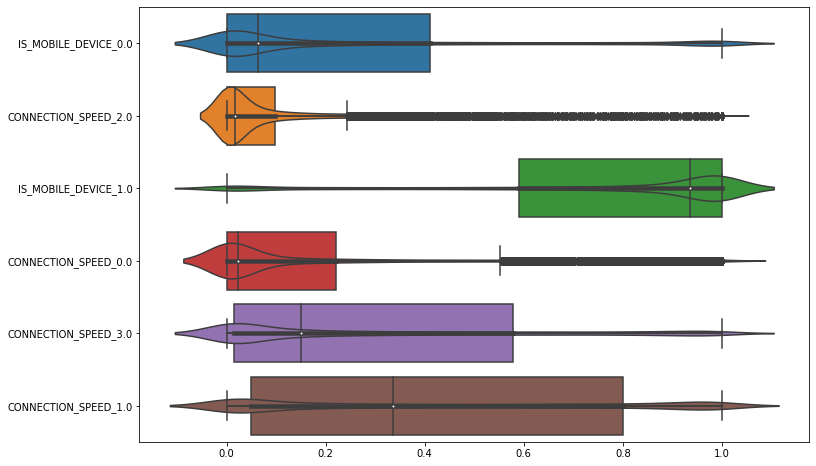

In [184]:
# veo la media de esos valores
plt.figure(figsize=(12,8))

sns.violinplot(data=X_train.loc[:,cols_with_nans.index], orient='h')
sns.boxplot(data=X_train.loc[:,cols_with_nans.index], orient='h')

In [188]:
X_train.loc[:,cols_with_nans.index].plot.hist(subplots=True, figsize=(10,12))

In [193]:
# es un solo dato, llenamos con la media
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# imputer.fit_transform(X_train)

X_train = X_train.fillna(X_train.mean())

In [194]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# candidatos = [{
#     "learner": LGBMClassifier,
#     "param_grid": model_selection.ParameterGrid({
#            "n_estimators": [10000],
#            "num_leaves": [200, 30, 40],
#            "max_depth": [-1, 3, 5, 10],
#            "min_child_samples": [100, 20],
#     }),
#     "train_params": {
#         "early_stopping_rounds": 10,
#         "eval_metric": "auc", 
#         "eval_set": True,
#         "verbose": 25
#     } 
# }, {
#     "learner": ExtraTreesClassifier,
#     "param_grid": model_selection.ParameterGrid({
#            "n_estimators": [1000],
#            "min_samples_leaf": [10, 20, 40, 100],
#     })
# }]

candidatos = [
{
    "learner": LGBMClassifier,
    "param_grid": model_selection.ParameterGrid({
           "n_estimators": [10000],
           "num_leaves": [200],
           "max_depth": [3],
           "min_child_samples": [100],
    }),
    "train_params": {
        "early_stopping_rounds": 10,
        "eval_metric": "auc", 
        "eval_set": True,
        #"verbose": 25
    } 
},
{
    "learner": XGBClassifier,
    "param_grid": model_selection.ParameterGrid({
        'min_child_weight': [0.8],
        'gamma': [0],#[0.5, 1, 1.5, 2, 5],
        'subsample': [0.8],#[0.6, 0.8, 1.0],
        'colsample_bytree': [0.6],#[0.6, 0.8, 1.0],
        'max_depth': [4],
        "learning_rate":[0.1],
        "n_estimators":[10000],
        #'max_leaves':[200]
        #"lambda":[1],
        #"alpha":[0]
    }),
     "train_params": {
        "early_stopping_rounds": 10,
        "eval_metric": "auc", 
        "eval_set": True,
        #"verbose": 3,
        #"tree_method":"hist",
    } 
},
{
    "learner": RandomForestClassifier,
    "param_grid": model_selection.ParameterGrid({
        'max_depth': [4],
        "n_estimators":[600],
        #"verbose": [2],
    }),
     "train_params": {
    } 
}
]

In [195]:
folds = list(model_selection.KFold(n_splits=3, shuffle=True, random_state=7).split(X_train))
#folds = list(model_selection.StratifiedKFold(n_splits=3, shuffle=True).split(X_train, y_train))


In [196]:
dt_now = str(np.datetime64('now'))
res = []
bestRes = 0
# tiene label de los anteriores a octubre
bestProbs = y_train
acumProbs = []
fi = [] # podemos usar como explicación

for candidate in candidatos:
    for paramIndex, params in zip(range(len(candidate["param_grid"])), candidate["param_grid"]):
        trainParams = candidate.get("train_params", {})
        valid_probs = []
        test_probs = []
        
        print(f"Start training {candidate['learner'].__name__} - index {paramIndex}")
              
        for i, (train_idx, valid_idx) in enumerate(folds):
            Xt = X_train.iloc[train_idx]
            yt = y_train.loc[X_train.index].iloc[train_idx]

            Xv = X_train.iloc[valid_idx]
            yv = y_train.loc[X_train.index].iloc[valid_idx]
            
            if "eval_set" in trainParams:
                trainParams["eval_set"] = [(Xt, yt), (Xv, yv)]
            
            learner = candidate["learner"](**params)
            
            learner.fit(Xt, yt, **trainParams)

            # por cada xv (ejemplos no vistos) se agrega su probabilidad de cross_validation
            valid_probs.append(
                pd.Series(
                    learner.predict_proba(Xv)[:, -1], 
                    index=Xv.index, 
                    name="SCORE")
            )
            
            # probabilidad del dataset completo con el fit [(Xt, yt), (Xv, yv)]
            ypred = learner.predict_proba(X_test)[:, -1]
            test_probs.append(
                pd.Series(
                    ypred,
                    index=X_test.index, 
                    name=f"clf_{candidate['learner'].__name__}_{paramIndex}_fold_{i}"
                )
            )
            
            fi.append(
                pd.Series(
                    learner.feature_importances_ / learner.feature_importances_.sum(), 
                    index=Xt.columns,
                    name=f"clf_{candidate['learner'].__name__}_{paramIndex}_fold_{i}"
                )
            )
        
        valid_probs = pd.concat(valid_probs)
        
        acumProbs.extend(test_probs)
        
        # para los valores anteriores a octubre que no fueron vistos en cross_validation
        cres = roc_auc_score(y_train, valid_probs.loc[y_train.index])
        
        # para el dataset completo
        cres_test = roc_auc_score(y_test, learner.predict_proba(X_test)[:, -1])
        
        cols = ["learner"]
        vals = [candidate["learner"].__name__]
        
        for p in params:
            cols.append("param_" + p)
            vals.append(params[p])
                
        cols.append("score val")
        vals.append(cres)
        
        cols.append("score test")
        vals.append(cres_test)
        
        res.append(pd.DataFrame([vals], columns=cols))
        
        print("*"*20)
        print(pd.concat(res))
        print("*"*20)
        
        if cres > bestRes:
            test_probs = pd.concat(test_probs, axis=1, sort=False).mean(axis=1)
            test_probs.index.name="USER_ID"
            test_probs.name="SCORE"
            bestProbs = test_probs
            bestRes = cres
        
        print(f"Start training {candidate['learner'].__name__} - index {paramIndex}")

In [261]:
bestProbs.index = bestProbs.index.astype('int32')
bestProbs.to_csv(f"../output/benchmark-{dt_now}.csv", header=True)

In [253]:
pd.concat(res,sort=False).sort_values("score val", ascending=False)[["learner","score val", "score test"]]

,learner,score val,score test
0,XGBClassifier,0.848988,0.957035
0,LGBMClassifier,0.844285,0.964080
0,RandomForestClassifier,0.843249,0.970786


In [198]:
ypred_lgb = pd.concat(acumProbs,axis=1).iloc[:,0:3].mean(axis=1)
ypred_xgb = pd.concat(acumProbs,axis=1).iloc[:,3:6].mean(axis=1)
ypred_rf = pd.concat(acumProbs,axis=1).iloc[:,6:9].mean(axis=1)

In [199]:
roc_auc_score(y_test,ypred_lgb), roc_auc_score(y_test,ypred_xgb), roc_auc_score(y_test,ypred_rf)

(0.9635698659390615, 0.9597870224002977, 0.9706739740225412)

In [206]:
pd.concat(acumProbs,axis=1).to_csv(f'../output/bench_all_{dt_now}.csv', header=True)

In [205]:
pd.concat(fi, axis=1).to_csv(f'../output/fi_all_{dt_now}.csv', header=True)

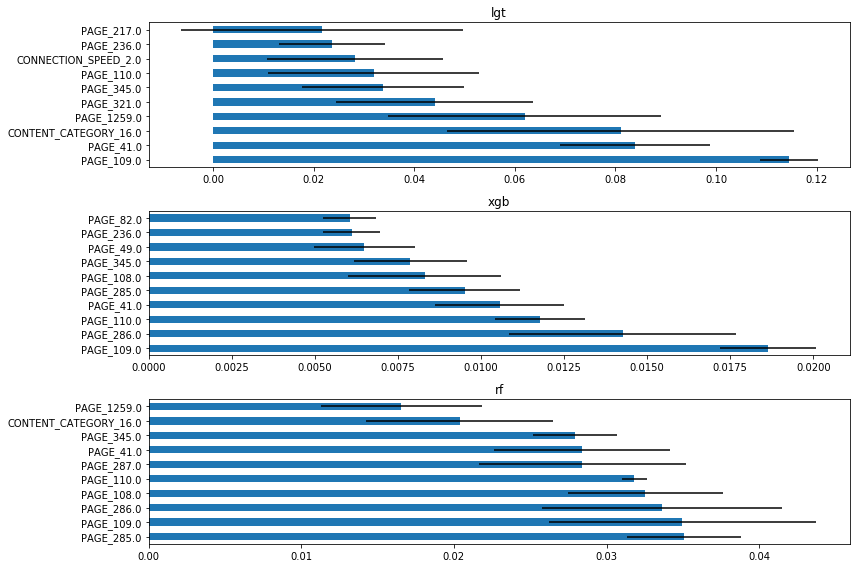

In [250]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1)
ranges = [["lgt",0,3, ax0], ["xgb",3,6, ax1], ["rf",6,9, ax2]]

for name, ini, fin, ax in ranges:
    
    means = pd.concat(fi,axis=1).iloc[:,ini:fin].mean(axis=1).sort_values(ascending=False).iloc[0:10]
    stds = pd.concat(fi,axis=1).iloc[:,ini:fin].std(axis=1)[means.index]
    
    means.plot.barh(xerr=stds, figsize=(12,8), align='center', ax=ax, title=name)
    #sns.barplot(data=means)
plt.tight_layout()


In [264]:
# ypred_lgb.index = ypred_lgb.index.astype('int32')
# ypred_lgb.name="SCORE"
# ypred_lgb.to_csv(f"../output/benchmark-lgb-{dt_now}.csv", header=True)

In [272]:
trainer =  {
    "learner": XGBClassifier,
    "param_grid": {
        'min_child_weight': 0.8,
        'gamma': 0,#[0.5, 1, 1.5, 2, 5],
        'subsample': 0.8,#[0.6, 0.8, 1.0],
        'colsample_bytree': 0.6,#[0.6, 0.8, 1.0],
        'max_depth': 4,
        "learning_rate":0.1,
        "n_estimators":10000,
        #'max_leaves':[200]
        #"lambda":[1],
        #"alpha":[0]
    },
     "train_params": {
        "early_stopping_rounds": 12,
        "eval_metric": "auc", 
        "eval_set": [(X_train, y_train)],
        #"verbose": 3,
        #"tree_method":"hist",
    } 
}

model = trainer["learner"](**trainer["param_grid"])
model.fit(X_test, y_test,  **trainer["train_params"])


[0]	validation_0-auc:0.806849
Will train until validation_0-auc hasn't improved in 12 rounds.
[1]	validation_0-auc:0.822373
[2]	validation_0-auc:0.822032
[3]	validation_0-auc:0.821669
[4]	validation_0-auc:0.821083
[5]	validation_0-auc:0.824186
[6]	validation_0-auc:0.823519
[7]	validation_0-auc:0.823429
[8]	validation_0-auc:0.823916
[9]	validation_0-auc:0.824246
[10]	validation_0-auc:0.823931
[11]	validation_0-auc:0.823967
[12]	validation_0-auc:0.823882
[13]	validation_0-auc:0.824003
[14]	validation_0-auc:0.82366
[15]	validation_0-auc:0.823129
[16]	validation_0-auc:0.82285
[17]	validation_0-auc:0.821639
[18]	validation_0-auc:0.821244
[19]	validation_0-auc:0.821068
[20]	validation_0-auc:0.820687
[21]	validation_0-auc:0.820345
Stopping. Best iteration:
[9]	validation_0-auc:0.824246



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=0.8, missing=None, n_estimators=10000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [274]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,-1])

0.9968197263828241

In [278]:
predictions = pd.Series(
 model.predict_proba(X_test)[:,-1],
    index=X_test.index.astype('int32'),
    name="SCORE")


In [280]:
predictions.to_csv(f"../output/submition-xgb-{dt_now}.csv", header=True)